## Building the graph

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypotheses and it's impacts.

In [1]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [2]:
data = pd.read_csv("colaboration_comments.csv")

In [3]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [4]:
data = data[data['BODY'].notna() & data['BODY'].str.contains('python',case=False)]


In [5]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [6]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
260,berkerpeksag,2015-01-01T01:43:01Z,I'd start with `$ PYTHONPATH=. python ...` here.,spotify
323,CyberShadow,2015-01-01T10:14:42Z,I wasn't thinking of C++ iterators when I chos...,D-Programming-Language
499,ragv,2015-01-01T12:01:10Z,hmm... the inner `try ... except` works along ...,scikit-learn
530,Garrett-R,2015-01-01T12:22:36Z,"@charris, are you asking if we even need to us...",numpy
620,mister-roboto,2015-01-01T13:08:10Z,TESTS FAILED\n Mr.roboto url : http://jenkins....,plone
...,...,...,...,...
634537,linas,2015-02-28T04:37:29Z,python eval should work with the atompsace tha...,opencog
634547,bgoertzel,2015-02-28T04:42:36Z,"Well, right now Shujing's pattern miner relies...",opencog
634580,bgoertzel,2015-02-28T04:52:59Z,"The whole design of the CogServer, SpaceTimeCo...",opencog
634640,tisto,2015-02-28T05:29:24Z,@thet This breaks the Plone 4.3 tests for Pyth...,plone


In [7]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
mister-roboto     484
stvstnfrd          79
boegel             71
cewing             64
jeromekelleher     37
                 ... 
jeffdonahue         1
jeffdh5             1
jef-n               1
jdurgin             1
007lva              1
Name: source, Length: 2519, dtype: int64

In [8]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    2519.000000
mean        2.507344
std        10.332203
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       484.000000
Name: source, dtype: float64

In [9]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['plone', 'edx', 'mozilla', 'hpcugent', 'Stanford-Online', 'apache',
       'django', 'scikit-learn', 'bartvm', 'Homebrew',
       ...
       'Alexpux', 'novapost', 'hgrecco', 'idaholab', 'Tribler', 'mixxxdj',
       'kenbeese', 'krux', 'mrjbq7', 'superdesk'],
      dtype='object', name='source', length=353)

In [10]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [11]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
260,berkerpeksag,2015-01-01T01:43:01Z,I'd start with `$ PYTHONPATH=. python ...` here.,spotify
499,ragv,2015-01-01T12:01:10Z,hmm... the inner `try ... except` works along ...,scikit-learn
530,Garrett-R,2015-01-01T12:22:36Z,"@charris, are you asking if we even need to us...",numpy
620,mister-roboto,2015-01-01T13:08:10Z,TESTS FAILED\n Mr.roboto url : http://jenkins....,plone
1182,Keats,2015-01-01T16:09:24Z,remove all those lines below + pygments/ipytho...,WeAreWizards
...,...,...,...,...
634470,jdkasten,2015-02-28T04:15:09Z,util.dump_ijsonserializable - I guess I don't ...,letsencrypt
634537,linas,2015-02-28T04:37:29Z,python eval should work with the atompsace tha...,opencog
634547,bgoertzel,2015-02-28T04:42:36Z,"Well, right now Shujing's pattern miner relies...",opencog
634580,bgoertzel,2015-02-28T04:52:59Z,"The whole design of the CogServer, SpaceTimeCo...",opencog


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [12]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [13]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
M4rtinK           0.000344
ruda              0.000517
daira             0.000517
egabancho         0.000517
sej7278           0.000689
                    ...   
jeromekelleher    0.076446
cewing            0.083968
boegel            0.146694
stvstnfrd         0.163223
mister-roboto     1.000000
Name: source, Length: 1250, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [14]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
18F                       [DavidEBest, afeld, cmc333333, khandelwal, kon...
4teamwork                                        [jone, lukasgraf, phgross]
Alexpux                                            [Alexpux, bpisoj, rossy]
BVLC                                         [jeffdonahue, longjon, philkr]
BinaryAnalysisPlatform                                [geohot, ivg, maurer]
                                                ...                        
wizzomafizzo                                [Kaitnoday, Tsunder, chrmoritz]
xbmc                             [Montellese, jimfcarroll, tamland, topfs2]
ymy513                                                           [ppwwyyxx]
zestedesavoir                      [SpaceFox, firm1, firm2, gustavi, poulp]
zopefoundation                     [davisagli, freddrake, mgedmin, tseaver]
Name: AUTHOR, Length: 353, dtype: object

In [15]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [16]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 1220


#### Number of edges in the graph

In [17]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 4658


#### Density of the graph

In [18]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

743590

In [19]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.006264204736481125


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [20]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [21]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
DavidEBest,0.002066,1
afeld,0.004132,2
cmc333333,0.024793,12
khandelwal,0.010331,5
konklone,0.001033,1


##### Adding clustering and degree metrics

In [22]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,1220.000000,1220.000000,1220.000000,1220.000000
mean,0.007107,3.552459,0.826500,0.006264
std,0.030062,14.576652,0.360677,0.007669
min,0.000344,1.000000,0.000000,0.000820
25%,0.002066,1.000000,1.000000,0.001641
50%,0.004132,2.000000,1.000000,0.003281
75%,0.006198,3.000000,1.000000,0.007383
max,1.000000,484.000000,1.000000,0.035275


In [23]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,1220.000000
mean,7.636066
std,9.347911
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,43.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

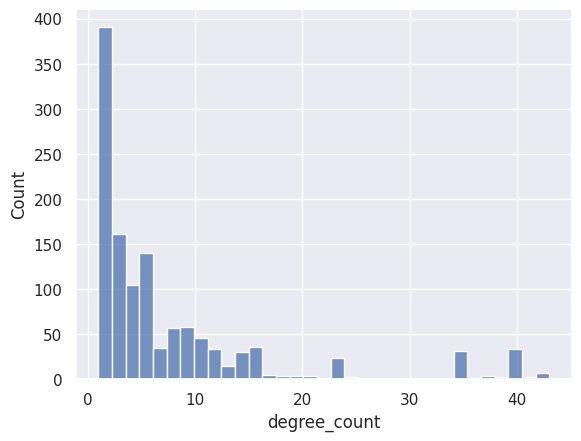

In [24]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [25]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [26]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [27]:
data['degree'].describe().to_frame()

,degree
count,1219.000000
mean,0.006262
std,0.007671
min,0.000820
25%,0.001641
50%,0.003281
75%,0.007383
max,0.035275


In [28]:
data['focus'].describe().to_frame()

,focus
count,1.219000e+03
mean,3.651717e-02
std,5.965538e-02
min,1.000000e-10
25%,1.057082e-02
50%,2.325581e-02
75%,3.594080e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

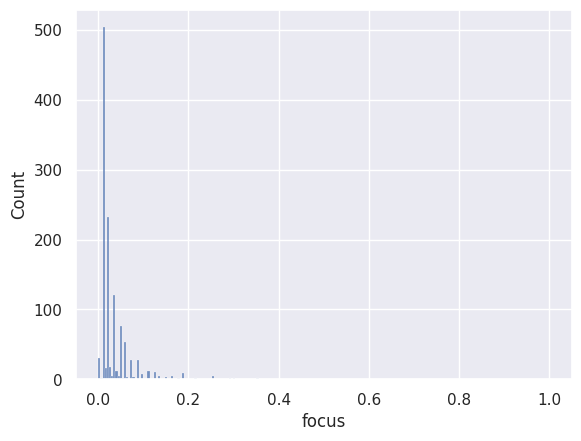

In [29]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

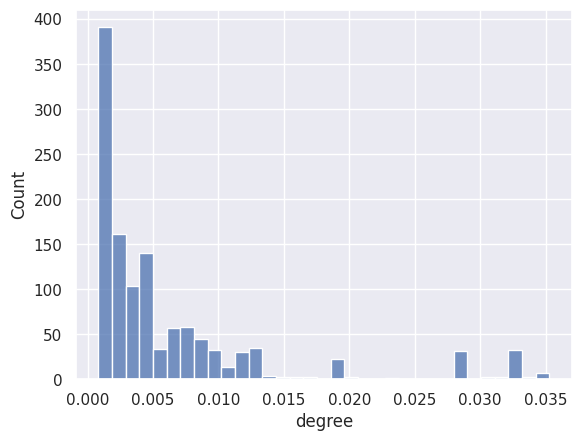

In [30]:
sns.histplot(data['degree'])

In [31]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

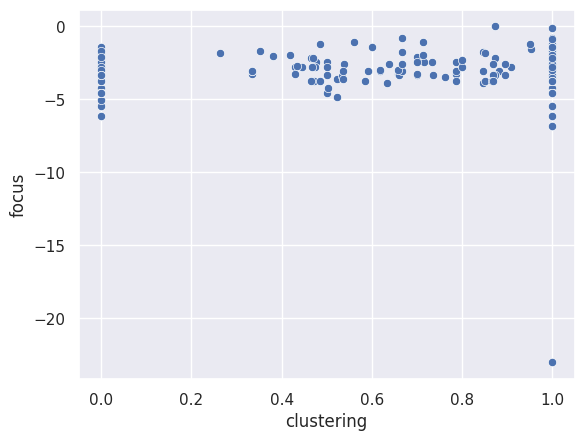

In [32]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [33]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
stvstnfrd,1.000000e+00,79,0.873754,0.035275,43
boegel,8.985201e-01,71,1.000000,0.008203,10
jeromekelleher,4.672304e-01,37,1.000000,0.002461,3
bartvm,4.422033e-01,36,0.666667,0.003281,4
ogrisel,4.178618e-01,35,1.000000,0.011485,14
...,...,...,...,...,...
serge-sans-paille,2.114165e-03,1,0.000000,0.000820,1
daira,1.057083e-03,1,1.000000,0.001641,2
ruda,1.057083e-03,1,1.000000,0.001641,2


### Residuals

In [34]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.400
Date:                Mon, 29 May 2023   Prob (F-statistic):              0.122
Time:                        16:39:56   Log-Likelihood:                 1708.6
No. Observations:                1219   AIC:                            -3413.
Df Residuals:                    1217   BIC:                            -3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0426      0.004      9.973      0.000       0.034       0.051
clustering    -0.0073      0.005     -1.549      0.122      -0.017       0.002
==============================================================================
Omnibus:                     1727.202   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513321.354
Skew:                           7.931   Prob(JB):                         0.00
Kurtosis:                     102.271   Cond. No.                         4.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.007335,0.004735,0.121625


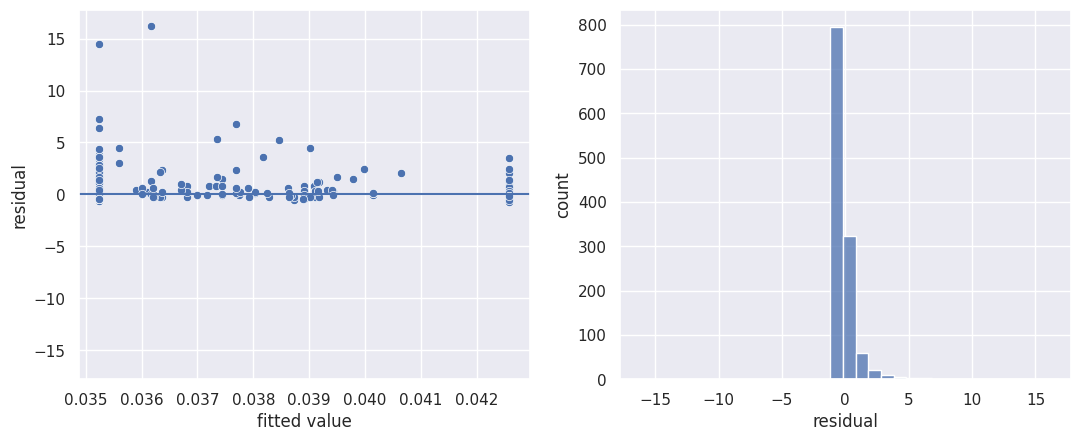

In [37]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [38]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     20.85
Date:                Mon, 29 May 2023   Prob (F-statistic):           1.25e-09
Time:                        16:39:58   Log-Likelihood:                -1775.5
No. Observations:                1219   AIC:                             3557.
Df Residuals:                    1216   BIC:                             3572.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5324      0.075    -47.213      0.000      -3.679      -3.386
clustering    -0.4840      0.085     -5.677      0.000      -0.651      -0.317
degree        17.6274      4.010      4.396      0.000       9.760      25.495
==============================================================================
Omnibus:                     1322.298   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           436813.921
Skew:                          -4.655   Prob(JB):                         0.00
Kurtosis:                      95.268   Cond. No.                         178.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.484033,0.085260,0.000000
degree,17.627436,4.009914,0.000012


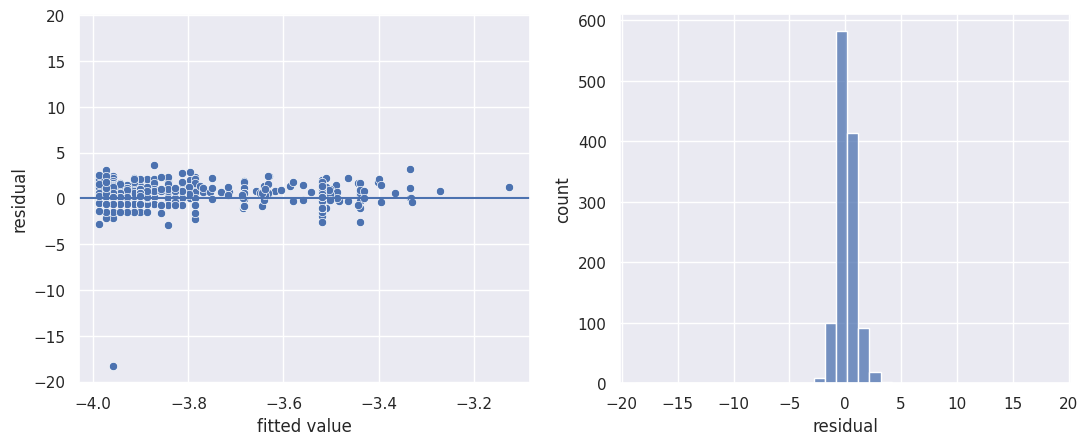

In [41]:
result.plot_residuals()

## Saving the graph

In [42]:
import netpixi

In [43]:
gt_save(g, 'colabs_python.net.gz')